In [3]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import h5py as h5
import time
import os

def read_dim_fromfile(name):
    file = h5.File(name, "r")
    Nx = int(file.get("LBE3D").attrs["lbe_sx"][0])
    Ny = int(file.get("LBE3D").attrs["lbe_sy"][0])
    Nz = int(file.get("LBE3D").attrs["lbe_sz"][0])
    dt = int(file.get("LBE3D").attrs["lbe_diag_nsteps"][0])
    t  = int(file.get("LBE3D").attrs["lbe_steps"][0])
    steps = int(t / dt)
    print("Nx Ny Nz = %d %d %d"%(Nx,Ny,Nz))
    print("t : %d;  dt : %d;  steps : %d"%(t,dt,steps))
    return Nx,Ny,Nz,t,dt,steps
    file.close()

def read_field_fromfile(name, field):
    file = h5.File(name, "r")
    name_field="/LBE3D/"+field
    f = np.zeros((Nx,Ny,Nz))
    f[:,:,:] = file.get(str(name_field))[...]
    file.close()
    return f

def swap_XZ(Nx,Nz):
    return Nz,Nx;

test = "SCMP_LAPLACE_SHEARSTRESSTENSOR/"

direc = "/home/matti/programming/lbe-direct/src/tests/"+test
direcRUN = direc+"RUN/"
print("Creation of the RUN/ folder time: "+time.ctime(os.path.getctime(direcRUN)))

name=direcRUN+"density_t.0.h5"
Nx,Ny,Nz,tf,dt,steps = read_dim_fromfile(name)
#Nx,Nz = swap_XZ(Nx,Nz);

def comp_nu(tau):
    return (tau-0.5)/3.0
tau1=1
tau2=1
nu1=comp_nu(tau1)
nu2=comp_nu(tau2)

rho1 = np.zeros((steps,Nx,Ny,Nz))
rho2 = np.zeros((steps,Nx,Ny,Nz))
vx   = np.zeros((steps,Nx,Ny,Nz))
vy   = np.zeros((steps,Nx,Ny,Nz))
vz   = np.zeros((steps,Nx,Ny,Nz))
for i in range(0,steps):
    t = i*dt
    name=direcRUN+"density_t.%d.h5"%t
    rho1[i,:,:,:] = read_field_fromfile(name,"rho1")
    rho2[i,:,:,:] = read_field_fromfile(name,"rho2")
    name=direcRUN+"velocity_t.%d.h5"%t
    vx[i,:,:,:]   = read_field_fromfile(name,"vx")
    vy[i,:,:,:]   = read_field_fromfile(name,"vy")
    vz[i,:,:,:]   = read_field_fromfile(name,"vz")
rhoN = (rho1-rho2)/(rho1+rho2)

#read sigma
lap = np.loadtxt(direc+"laplace_clean.dat")
print(lap[:,-1])
sigma = lap[-1,-1]
print("sigma = %f"%sigma)

# components of the simmetrical tensors:
# 0: xx; 1: xy; 2: xz
# _: yx; 3: yy; 4: yz
# _: zx; _: zy; 5: zz

#read SST
SST = np.zeros((steps,Nz,6))
with open(direc+"sst_xx.dat", 'r') as f:
    SST[:,:,0] = np.loadtxt(f)
with open(direc+"sst_xy.dat", 'r') as f:
    SST[:,:,1] = np.loadtxt(f)
with open(direc+"sst_xz.dat", 'r') as f:
    SST[:,:,2] = np.loadtxt(f)
with open(direc+"sst_yy.dat", 'r') as f:
    SST[:,:,3] = np.loadtxt(f)
with open(direc+"sst_yz.dat", 'r') as f:
    SST[:,:,4] = np.loadtxt(f)
with open(direc+"sst_zz.dat", 'r') as f:
    SST[:,:,5] = np.loadtxt(f)

def deriv5(f,x):
    return ( (-f[:,x+2] + 8.0*f[:,x+1] - 8.0*f[:,x-1] + f[:,x-2])/12.0 )
def deriv3(f,x):
    return ( (f[:,x+1] - f[:,x-1])/2.0 )
deriv = deriv3

Nx2 = int(Nx/2)
Ny2 = int(Ny/2)
n     = np.zeros((steps,Nz,3))
dv_dx = np.zeros((steps,Nz,3))
dv_dy = np.zeros((steps,Nz,3))
dv_dz = np.zeros((steps,Nz,3))
# DrhoN_mod = np.zeros((steps,Nz))
for i in range(2,Nz-2):
    #compute rho_N derivative for X=Nx/2, Y=Ny/2, use 5 point derivative
    n[:,i,0] = deriv(rhoN[:,:,Ny2,i]  , Nx2); #derivative along X
    n[:,i,1] = deriv(rhoN[:,Nx2,:,i]  , Ny2); #derivative along Y
    n[:,i,2] = deriv(rhoN[:,Nx2,Ny2,:], i);   #derivative along Z
    #normalize to get n
    # th = np.zeros((np.shape(n[:,0,0]))) #+ 1e-1
    # DrhoN_mod[:,i] = np.maximum(np.sqrt(n[:,i,0]**2 + n[:,i,1]**2 + n[:,i,2]**2),th)
    # DrhoN_mod[:,i] = np.sqrt(n[:,i,0]**2 + n[:,i,1]**2 + n[:,i,2]**2)
    # n[:,i,0] /= DrhoN_mod[:,i]
    # n[:,i,1] /= DrhoN_mod[:,i]
    # n[:,i,2] /= DrhoN_mod[:,i]
    # compute dervatives of vx,vy,vz in all directions
    dv_dx[:,i,0] = deriv(vx[:,:,Ny2,i], Nx2) #derivative along X
    dv_dx[:,i,1] = deriv(vy[:,:,Ny2,i], Nx2)
    dv_dx[:,i,2] = deriv(vz[:,:,Ny2,i], Nx2)
    dv_dy[:,i,0] = deriv(vx[:,Nx2,:,i], Ny2) #derivative along Y
    dv_dy[:,i,1] = deriv(vy[:,Nx2,:,i], Ny2)
    dv_dy[:,i,2] = deriv(vz[:,Nx2,:,i], Ny2)
    dv_dz[:,i,0] = deriv(vx[:,Nx2,Ny2,:], i) #derivative along X
    dv_dz[:,i,1] = deriv(vy[:,Nx2,Ny2,:], i)
    dv_dz[:,i,2] = deriv(vz[:,Nx2,Ny2,:], i)

# cosi filtro fuori le normali lontane dall' interfaccia (che hanno il modulo di DrhoN piu' piccolo)
# for i in range(steps):
#     filt = np.max(DrhoN_mod[i,:])*0.1
#     n[i,DrhoN_mod[i,:]<filt,:] = 0.0 

# components of the simmetrical tensor:
# 0: xx; 1: xy; 2: xz
# _: yx; 3: yy; 4: yz
# _: zx; _: zy; 5: zz

# P1 = (nu1*rho1+nu2*rho2)*(dvi/dxj + dvj/dxi)
P1 = np.zeros((steps,Nz,6))
rhonu = (nu1*rho1[:,Nx2,Ny2,:] + nu2*rho2[:,Nx2,Ny2,:])
P1[:,:,0] = rhonu * (dv_dx[:,:,0] * 2) 
P1[:,:,1] = rhonu * (dv_dy[:,:,0] + dv_dx[:,:,1])
P1[:,:,2] = rhonu * (dv_dz[:,:,0] + dv_dx[:,:,2])
P1[:,:,3] = rhonu * (dv_dy[:,:,1] * 2)
P1[:,:,4] = rhonu * (dv_dz[:,:,1] + dv_dy[:,:,2])
P1[:,:,5] = rhonu * (dv_dz[:,:,2] * 2)

# P2 = sigma*(identity - n (tensor product) n)
P2 = np.zeros((steps,Nz,6))
P2[:,:,0] = (1 - n[:,:,0]*n[:,:,0]) * sigma
P2[:,:,1] = (  - n[:,:,0]*n[:,:,1]) * sigma
P2[:,:,2] = (  - n[:,:,0]*n[:,:,2]) * sigma
P2[:,:,3] = (1 - n[:,:,1]*n[:,:,1]) * sigma
P2[:,:,4] = (  - n[:,:,1]*n[:,:,2]) * sigma
P2[:,:,5] = (1 - n[:,:,2]*n[:,:,2]) * sigma


Creation of the RUN/ folder time: Thu Mar 13 16:29:46 2025
Nx Ny Nz = 64 64 64
t : 2000;  dt : 500;  steps : 4
[0.00300155 0.0224362  0.0252723  0.0216226 ]
sigma = 0.021623


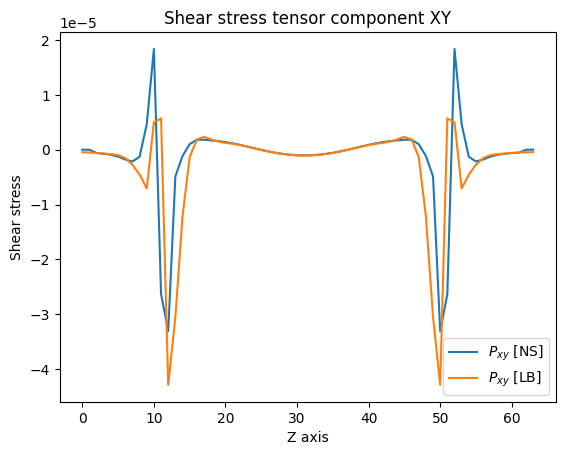

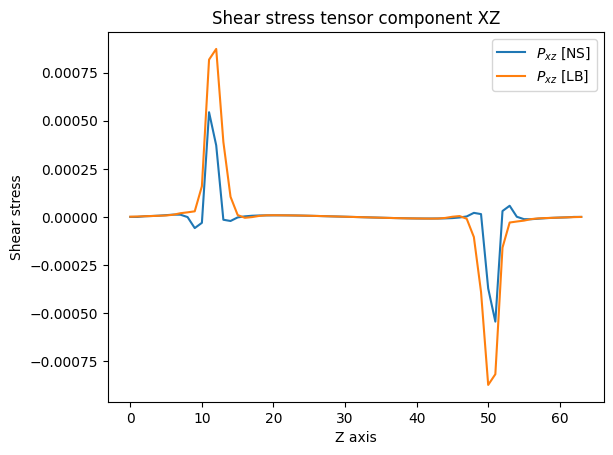

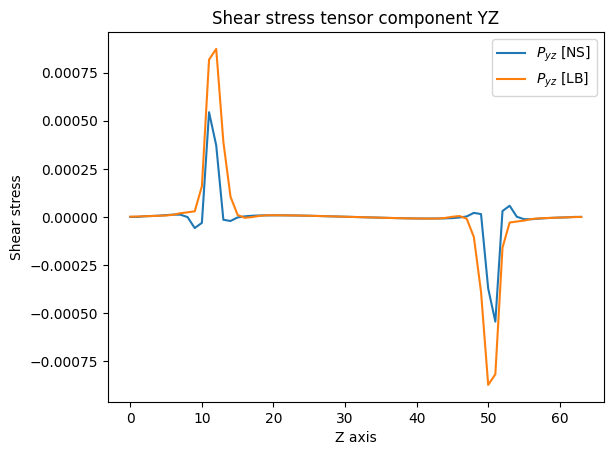

In [9]:
P=P1+P2

i = -1

_ = plt.figure(1)
_ = plt.plot(P[i,:,1], label=r'$P_{xy}$ [NS]')
_ = plt.plot(SST[i,:,1], label=r'$P_{xy}$ [LB]')
_ = plt.title('Shear stress tensor component XY')
_ = plt.ylabel('Shear stress')
_ = plt.xlabel('Z axis')
_ = plt.legend()

_ = plt.figure(2)
_ = plt.plot(P[i,:,2], label=r'$P_{xz}$ [NS]')
_ = plt.plot(SST[i,:,2], label=r'$P_{xz}$ [LB]')
_ = plt.title('Shear stress tensor component XZ')
_ = plt.ylabel('Shear stress')
_ = plt.xlabel('Z axis')
_ = plt.legend()

_ = plt.figure(3)
_ = plt.plot(P[i,:,4], label=r'$P_{yz}$ [NS]')
_ = plt.plot(SST[i,:,4], label=r'$P_{yz}$ [LB]')
_ = plt.title('Shear stress tensor component YZ')
_ = plt.ylabel('Shear stress')
_ = plt.xlabel('Z axis')
_ = plt.legend()

# _ = plt.figure(4)
# _ = plt.plot(P[i,:,0], label=r'$P_{xx}$ [NS]')
# _ = plt.plot(SST[i,:,0], label=r'$P_{xx}$ [LB]')
# _ = plt.xlabel('Z axis')
# _ = plt.legend()